# Build an Image-based Recommender System (IBRS)

This notebook illustrates how an IBRS works in e-commerce web-site

## Idea behind an IBRS

<b> Hypothesis </b> : A user who clicks on a product is usually interested in products with a similar style (with the same texture). As an example, Fig. 1 shows a user who is looking for a tiled shirt.

<img src="usefulImg/hypothese.png" width=400px/>
<center> <b>Figure 1.</b> the user consults a tiled shirt. </center>

<b> Objectives </b> : Propose to the user articles with similar styles and textures compared to the image of the referenced product.

The dataset used in this notebook (file ```dataset.zip```) is structured as follow

```
dataset
    |
    |-- images
    |      |
    |      |-- img_1.jpg
    |      |-- img_2.jpg
    |      |   ...
    |      |-- img_n.jpg
    |
    |-- metadata.json
```
Folder ```images``` contains images of products. Product of our dataset are fashion products only : ```Fashion Men, Fashion Women, Fashion Babies and Kids```. The total number of products is $n=1655$.

File ```metadata.json``` contains useful metadata for all products of our dataset. It contains 1655 lines, each line corresponding to a product. The following is an example of metadata of a product :
    
```
{
    "ID": 7541,
    "title": "Christina Gavioli",
    "slug": "christina-gavioli-3",
    "category": ["Fashion Women", "Women Blouse and Dress"],
    "imPath": "images/Fashion Women/Women Blouse and Dress/CHRISTINA_GAVIOLI.jpg"
}
```

Import useful packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tarfile
import zipfile
import random
import urllib
import json
import sys
import os

We first need to unzip the dataset. Run the cell below to do that

In [2]:
zip_data = "dataset.zip"

with zipfile.ZipFile(zip_data, 'r') as data:
    data.extractall()

Let's generate our database of products (function ```generate_database()```) by creating a separate metadata file for each product and save all of them in the folder ```items metadata```.

In [3]:
def generate_database(metadata, folder):
    """
    This function reads metadata from metadata.json, creates a separate metadata file for each product and saves
    them in the folder specified by folder
    
    :param 
        - metadata: json file in which each line represents metadata for a product
        - folder: path where to save metadata files
    """
    
    # create the folder if not exist
    os.makedirs(folder, exist_ok=True)
    
    # initialize the list of products
    items = []
    
    print('[INFO] generating metadata file for each item ...')
    with open(metadata, 'r') as file :
        line = file.readline()
        while line :
            
            # read metadata of the current item
            item = eval(line.strip())
            
            # the file name is defined the ID of the product
            name = str(item['ID']) + '.json'
            path = os.path.join(folder, name)
            
            # save metadata file of the current item
            with open(path, 'w') as out:
                json.dump(item, out)
            
            # add ID of the current item in the list of items
            items.append(item['ID'])
            
            # read the next line (next item)
            line = file.readline()


In [4]:
generate_database(metadata='dataset/metadata.json', folder='items metadata')

[INFO] generating metadata file for each item ...


we can visualize item through the ```get_item()``` function

In [5]:
def get_item(ID):
    """    
    :param ID: id of a product
    :return item: dictionary of metadata of the corresponding product
    """
    
    folder = 'items metadata'
    file_name = str(ID) + '.json'
    
    with open(os.path.join(folder, file_name),'r') as file:
        item = eval(file.readline().strip())
        
    return item

def get_all_items():
    """
    
    :return items: list of dictionaries of product's metadata
    """
    
    folder = 'items metadata'
    items_path = os.listdir(folder)
    items = []
    
    for path in items_path:
        with open(os.path.join(folder, path),'r') as file:
            items.append(eval(file.readline().strip()))
        
    return items

let's visualize any item of our database. Note that we have 1655 items. Fill free to change the index in order to see other items

In [6]:
items = get_all_items()
print(items[10])

{'ID': 2957, 'title': 'Huile de nigelle', 'slug': 'huile-de-nigelle-2', 'category': ['Fashion Women', 'Women Perfume and Beauty'], 'imPath': 'images/Fashion Women/Women Perfume and Beauty/DSC_0430.jpg'}


Let's print 50 randomly selected products in our database with the function ```visualize_random_items()``` 

In [7]:
def visualize_random_items(items, n=50):
    """
    Randomly choose n items in the database and display them in a grib
    
    :param 
        - items: list of item's IDs
        - n : number of items to display. Default value = 50
    """
    # root folder where images data are stored
    root = "dataset"
    
    # randomly choose 50 items of products
    random_items = random.choices(items, k=n)
    
    # load images data of randomly choosed items
    images = []
    
    for item in random_items:
        images.append(mpimg.imread(os.path.join(root, item['imPath'])))
    
    # defining the grid
    cols = 10
    rows = n // cols
    
    # size of images in the grid
    fig = plt.figure(figsize = (10,10))

    axis = []

    for i, img  in enumerate(images):
        axis.append(fig.add_subplot(rows,cols,i+1))
        axis[i].imshow(img)
        plt.axis("off")
    
    # display the grid
    plt.show()

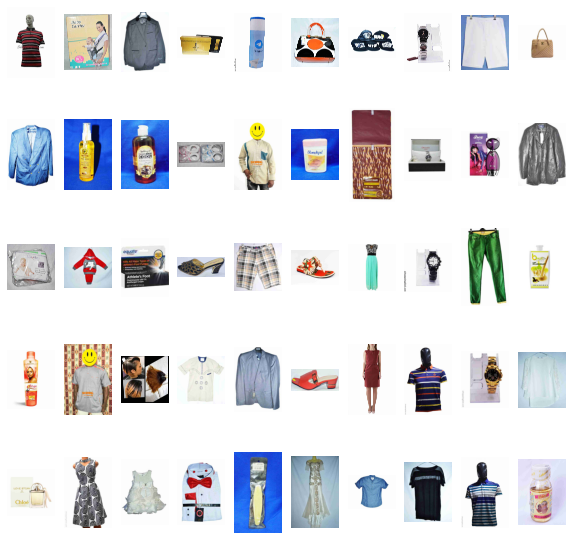

In [8]:
visualize_random_items(items)

The most important attributes in  metadatas of a product are ```ID, category``` and ```imPath```. Our objective is to add a new attribute ```IBSP``` (Image-based Similar Products) which will contain the list of related products, more specifically the list of image-based similar products. 

    
```
{
    "ID": 7541,
    "title": "Christina Gavioli",
    "slug": "christina-gavioli-3",
    "category": ["Fashion Women", "Women Blouse and Dress"],
    "imPath": "images/Fashion Women/Women Blouse and Dress/CHRISTINA_GAVIOLI.jpg",
    "IBSP" : [8544, 456, 123, 1569, 456]
}
```

The question is : <b>Given two product's images, how do we conclude that they have similar styles or textures ?</b> For example, given the tree images below, we can easilly (visually) say that shirt 2 is much similar to shirt 1 than shirt 3, but how does the computer understand these differences? <b><i>by learning embedding fartors of these images and comparing them to know their degree of similarity</i></b>.

<img src="usefulImg/similarities.png" width=400px>

<ol>
    <li> <b> Embeddings : </b> learnt during the feature representation step </li>
    <li> <b> Similarities : </b> </li>
    <li> <b> Top-N recommendation : </b> </li>
</ol>
    

# Image Features Representation Learning

Machine Learning algorithms have been widely and successfully used in various domains such as natural language processing, images recognition, speech recognition, machine translation, ... A variety of models such as Recurrent Neural Networks (RNNs) and Convolutional Neural Networks (CNNs) have been proposed. While RNNs are suitable for sequence data (speech, text, etc), CNNs are designed to process data that come in the form of multiple arrays, for example a colour image composed of three 2D arrays containing pixel intensities in the three colour channels.

CNNs have been applied with great success to the detection, segmentation and recognition of objects and region in images. Their success is essentially due to their ability to understand <b>embeddings</b> or <b>features representations</b> of images through their <i>convolutional</i> and <i>pooling</i> layers, stacked on top of each others. Figure 2 presentes the general architecture of CNNs

<img src="usefulImg/cnn-architecture.png" width=700px/>
<center><b>Figure 2.</b> General architecture of Convolutional Neural Networks</center>

CNNs are good <i><b>Image Feature Extractors</b></i> : the learned features become more and more representative as we go deeper into the network. The best layer to extract embeddings of an input image is then the fully connected layer (FC) next to the last convolutional layer (note that convolutional and pooling layers are known as convolutional layers). These embeddings also known as <b>image features</b> are vectors whose size varies (512, 1024, 2048, ...) depending on the model used.

Several CNN models exist and the most representative are <a href="https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf">AlexNet</a>, <a href="https://arxiv.org/pdf/1409.1556">VGG</a>, <a href="https://research.google.com/pubs/archive/43022.pdf">Inception (GoogLeNet)</a> and <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">ResNet</a>. All these models were trained on the ILSVRC (ImageNet Large Scale Visual Recognition Challenge) dataset, which contains 1.2 million images divided into 1000 categories. They learned to differentiate images from 1000 different categories.

Since we don't have enough data (1655 images with more than 20 categories) to train such models to be able to differentiate the images of our products, we can transfer the knowledge gained by one of these models from the imagenet dataset to our task of learning how to represent embeddings of images. This process is known as <b> Transfer Learning</b>.

For the purpose of this tutorial, I choosed to use the <a href="http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz">pretrained weights of GoogLeNet (Inception v1)</a> on the ILSVRC. Click the previous link to download the model. The ```.tgz``` downloaded file contains the file ```classify_image_graph_def.pb```, which is the pretrained weights (a tensorflow graph) of googlenet on the ImageNet challenge dataset. Figure 3 presents the architecture of GoogLeNet. The last convolutional layer of this architecture is a pooling layer named ```pool_3``` in the tensorflow graph. We then use this convolutional layer to extract features of an input image.
<img src='usefulImg/googlenet.png'/>
<center><b>Figure 3</b>: Architecture of the GoogLeNet model</center>

To extract images features, we need to define the following functions: 
<ul>
    <li> <b>download_googlenet()</b>: download the googlenet model which will be used to extract image features.</li>
    <li> <b>load_model()</b>: load the downloaded googlenet model (classify_image_graph_def.pb) in the tensorflow session.</li>
    <li> <b>extract_image_features()</b>: Extract image features of a given product</li>
    <li> <b>extract_features()</b>: extract image's features of all products in our database. All these features will be saved in the folder "image_features"</li>
</ul>

Import useful packages for features extraction

In [9]:
from PIL import Image
from tqdm import tqdm

import tensorflow as tf
import numpy as np

In [10]:
def download_googlenet():
    """
    Download and extract googlenet model from the downloaded tar file 
    """
    
    # location of the model
    model_url = "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz"
    
    # folder where to save the tar file to download
    save_dir = "googlenet"
    
    # create the save dir if it not already exists
    os.makedirs(save_dir, exist_ok=True)   
    
    # file name
    fname = "googlenet.tgz"
    
    # file path
    fpath = os.path.join(save_dir, "googlenet.tgz")
    
    # define a progress function
    def _progress(count, block_size, total_size):
        sys.stdout.write('\r[INFO] Downloading %s %.1f%%' % (fname, float(count * block_size) / float(total_size) * 100.0))
        sys.stdout.flush()
    
    # download with urllib
    fpath, _ = urllib.request.urlretrieve(model_url, fpath, _progress)
    
    print()
    statinfo = os.stat(fpath)
    print('Successfully downloaded', fname, statinfo.st_size, 'bytes.')
    tarfile.open(fpath, 'r:gz').extractall(save_dir)    

In [11]:
def load_model():
    """
    Load the model from the .pb file of GoogLeNet.
    """
    
    graph = 'googlenet/classify_image_graph_def.pb'
    
    # download the model if not already downloaded
    if not os.path.exists(graph):
        download_googlenet()
    
    print('[INFO] Loading the model ...')
    
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile(graph, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, name='')

In [12]:
def extract_image_features(item, output_dir):
    """
    Extract image's features of a product, save the corresponding features in a .npz format and add the attribute 
    'image_features' in metadata of the current product
    :param
        - item : metadatas of the product for which we extract image features
        - output_dir: folder where to saved the extracted features
    """
    
    # get the image path of the product
    im_path = os.path.join('dataset', item['imPath'])
    
    # initialize image features to an empty list
    img_features = []
    
    try:
        # open an preprocess image of the current product
        img = Image.open(im_path)
        img = img.convert('RGB')
        img = np.array(img)
        
        with tf.Session() as session:
            # extract image feature from the pool_3 node of the googlenet graph
            pool_3 = session.graph.get_tensor_by_name('pool_3:0')
            img_features = session.run(pool_3, {'DecodeJpeg:0': img})
            img_features = np.squeeze(img_features)
    except ValueError as verror:
        print('could not process image {}.\n ValueError : {}'.format(im_path, verror))
        
    # save extracted features in the folder 'image_features'
    fname = str(item['ID']) + ".npz"
    fpath = os.path.join(output_dir, fname)
    np.savetxt(fname=fpath, X=img_features, delimiter=',')
    
    # add attribute 'image_features' to metadata of this product
    item['image_features'] = fpath
    
    # update metadata of the current product
    with open(os.path.join('items metadata', str(item['ID']) + '.json'), 'w') as out:
        json.dump(item, out)

In [13]:
def extract_features(items):
    """
    Extract image's features for all products in our database
    
    :param items: list of metadatas of all products in our database
    """
    
    # load the googlenet model into the tensorflow session
    load_model()
    
    # output directory where to save extracted features
    output_dir = "images_features"
    
    # create the output directory if it not already exist
    os.makedirs(output_dir, exist_ok=True)
    
    # loop over items to extract image's features
    print('[INFO] extract images features of the entire database ...')
    
    with tqdm(total=len(items)) as progressbar:
        for item in items:
            extract_image_features(item, output_dir)
            progressbar.update(1)

Now, Let's call function ```extract_features()``` to extract images features of all products in the database. This may take several minutes

In [14]:
extract_features(items)

[INFO] Downloading googlenet.tgz 100.0%
Successfully downloaded googlenet.tgz 88931400 bytes.
[INFO] Loading the model ...
[INFO] extract images features of the entire database ...


100%|██████████| 1655/1655 [16:40<00:00,  1.65it/s]


Now each product as a new attribute ```image_features```, which specifies the location of the image's features of that product. Run the cell below to see it yourself

In [15]:
print(get_item(items[10]['ID']))

{'ID': 2957, 'title': 'Huile de nigelle', 'slug': 'huile-de-nigelle-2', 'category': ['Fashion Women', 'Women Perfume and Beauty'], 'imPath': 'images/Fashion Women/Women Perfume and Beauty/DSC_0430.jpg', 'image_features': 'images_features/2957.npz'}


Each extracted feature is a 2048D vector. Run the following cell to visualize embeddings of a given image

In [16]:
embedding = np.loadtxt('images_features/100.npz')
print('shape of the embedding :' ,embedding.shape)
print('values :', embedding)

shape of the embedding : (2048,)
values : [0.0756036  0.13697036 0.10896071 ... 0.37252694 0.38679773 0.09304915]


Every image in our database has is own embedding features. Since we want to recommend products with similar images compared to the referenced product, the similarity between two images can be defined as the <b>similarity between their corresponding embeddings</b>

# Similarities between images

To measure the similarity between two images, we need to measure the distance between the vectors of their corresponding features. One of the most commonly used similarity metric is the <b>cosine similary</b>, which measure the cosine of the angle between two vectors $u$ and $v$.

## cosine similarity

The cosine similarity between two vectors is define as follow : 
<center>
$
\large
    sim(u,v) = cos(\theta) = \frac{u \cdot v}{||u||_2||v||_2} = \frac{\sum_{i=1}^{n}u_i v_i}{\sqrt{\sum_{i=1}^{n}u_i^2}\sqrt{\sum_{i=1}^{n}v_i^2}}, \normalsize \text{ with }  u,v \in \mathbb{R}^n
$
</center>

where $u$ and $v$ are $n$-dimentional vectors (in our case $n=2048$ since our features have 2048 values each.) and $\theta$ is the angle between $u$ and $v$. The cosine similarity then depends on the angle between $u$ and $v$ :

<ul>
    <li>If $u$ and $v$ are very similar, their cosine similarity will be close to 1</li>
    <li>If they are dissimilar, the cosine similarity will take a smaller value</li>
</ul>
Figure 4 illustrates the cosine similarity between two vectors
<img src="usefulImg/cosine_sim.png" width=700px/>
<center><b>Figure 4</b>: The cosine of the angle between two vectors is a measure their similarity</center>

After computing cosine similarities between one embedding features and all the others, we can select the $k$ most similar products and recommend them to the user. This process is also known as <b>$k$ Nearest Neighbors ($k$-NN)</b> algorithm.

To compute nearest neighbors of images by using their embeddings features, we can use the library <a href="https://github.com/nmslib/nmslib">nmslib (Non-Metric Space Library)</a>, an efficient similarity search library and a toolkit for evaluation of $k$-NN methods for generic non-metric spaces.

## nmslib library

To compute nearest neighbors of our embedding features, nmslib create an index in which it places all embedding features. These embedding features in the created index are <b>data points</b>.

```python
# initialize the index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')

# place data points in the index. Here data is a list of embeddings features
index.addDataPointBatch(data)
index.createIndex({'post': 2}, print_progress=True)

# query for the nearest neighbours of the first datapoint
ids, distances = index.knnQuery(data[0], k=10)

```

```ids``` and ```distances``` are ids of images features with their corresponding similarities to the first data point ```data[0]```.

All we need to do is then to load all our images features in an nmslib index and call the function ```index.knnQuery()``` to compute the $k$ most similar products to recommend to the user.

<ul>
    <li> <b>create_nmslib_index()</b>: load all our images features in a nmslib index and save the created index as we will re-use it later</li>
    <li> <b>load_nmslib_index()</b>: load the created index</li>
    <li> <b>compute_nearest_neighbors()</b> : compute nearest neighbors of an images features</li>
    <li> <b>nearest_neighbors()</b>: compute nearest neighbors of all our images</li>
</ul>

Import nmslib package for k-NN computation

In [17]:
import nmslib

In [18]:
def create_nmslib_index(items, output_dir):
    """
    Loop over all our products and add their corresponding image features to an nmslib index and saved the index.
    
    :param 
        - items: list of metadatas of our products
        - output_dir: folder where to save the created index
    """
    
    # Initialize the index as description earlier. nmslib.DataType.DENSE_VECTOR just specifies that values of our 
    # image features are mostly non-zero values
    index = nmslib.init(method='hnsw', space='cosinesimil', data_type=nmslib.DataType.DENSE_VECTOR)
    
    # load our data points of image's features into the index. Note that we are setting the id of each data point 
    # to be the id of the corresponding product. 
    for item in items:
        
        # load the image features of the current item, located at item['image_features']. Recall that 
        # item['image_features'] returns the path to the image features of this item
        data_point = np.loadtxt(item['image_features'])
        
        # add the data point to the index
        index.addDataPoint(id=item['ID'], data=data_point)
    
    # create the index
    index.createIndex({'post': 2}, print_progress=True)
        
    # create the output directory if it doesn't exists    
    os.makedirs(output_dir, exist_ok=True)
    
    # the to the index in the file system
    index_path = os.path.join(output_dir, "index.bin")
    
    # save the index
    index.saveIndex(index_path, save_data=True)
    

Run the following cell to create the nmslib index and save it in the folder ```nmslib index```

In [19]:
save_dir = 'nmslib index'
create_nmslib_index(items=items, output_dir=save_dir)

In [20]:
def load_nmslib_index(saved_dir):
    """
    load the nmslib index
    
    :param saved_dir: directory in which the nmslib index has been saved 
    
    :return index: nmslib index
    """
    
    index_path = os.path.join(saved_dir, "index.bin")

    # initialize and load the index
    index = nmslib.init(method='hnsw', space='cosinesimil', data_type=nmslib.DataType.DENSE_VECTOR)
    index.loadIndex(index_path, load_data=True)

    return index    

In [21]:
def compute_nearest_neighbors(item, index, k=10):
    """
    Compute nearest neighbors of item and add attribute IBSP (Image Based Similar Product) its metadata
    
    :param
        - item : metadata of the item for which we wish to compute nearest neighbors
        - index : nmslib index where image's features are saved as data points
        - k : number of nearest neighbors to recommend
    """
    
    # load image's features of the product
    item_features = np.loadtxt(item['image_features'])
    
    # compute the nearest neigbors of this image features.
    # ids : list of ids of similar products
    # distances : distances for each id in ids
    ids, distances = index.knnQuery(vector=item_features, k=k+1)
    
    # initialize nearest neighbors of the current product
    nearest_neighbors = []
    
    # normalize distances 
    for iid, distance in zip(ids, distances):
        
        # lets not consider the similarity between this product and it self
        if iid != item['ID']:
            similarity = 1 - int((distance * 10000.0)) / 10000.0
            nearest_neighbors.append({
                'id': int(iid),
                'sim': similarity
            })
    
    # save nearest neighbors of the current product by adding attribute IBSP to its metadata
    item['IBSP'] = nearest_neighbors
    
    with open(os.path.join('items metadata', str(item['ID']) + '.json'), 'w') as out:
        json.dump(item, out)

In [22]:
def nearest_neighbors():
    """
    Compute nearest neighbors for all products in our database
    """
    print('[INFO] computing nearest neighbors for all images ...')
    
    # get metadata of all products
    items = get_all_items()
    
    # load the nmslib index. The nmslib index has been saved in the folder 'nmslib index'
    index = load_nmslib_index(saved_dir='nmslib index')
    
    # loop over all items to compute their nearest neighbors    
    with tqdm(total=len(items)) as progressbar:
        for item in items:
            compute_nearest_neighbors(item=item, index=index)
            progressbar.update(1)

Now let's call function ```nearest_neighbors()``` to compute nearest neighbors for all our products

In [23]:
nearest_neighbors()

[INFO] computing nearest neighbors for all images ...


100%|██████████| 1655/1655 [00:14<00:00, 112.90it/s]


Now, each of our item has new attribute ```IBSP``` (Image-Based Similar Product) in its metadata. Run the following cell to see metadata of the 50th product in our dataset. Fill free to change the index to see another item

In [24]:
item = items[100]
print(get_item(item['ID']))

{'ID': 2073, 'title': 'Sacs à main dame Fiorelli en cuir synthétique ', 'slug': 'sac-a-main-dame-fiorelli-en-cuir-synthetique', 'category': ['Fashion Women', 'Women Hand Bag'], 'imPath': 'images/Fashion Women/Women Hand Bag/DSC_0022_m9aphKf.jpg', 'image_features': 'images_features/2073.npz', 'IBSP': [{'id': 5539, 'sim': 0.8035}, {'id': 6569, 'sim': 0.8035}, {'id': 534, 'sim': 0.7904}, {'id': 1907, 'sim': 0.7876}, {'id': 526, 'sim': 0.7816}, {'id': 3223, 'sim': 0.7799}, {'id': 320, 'sim': 0.7767}, {'id': 6575, 'sim': 0.774}, {'id': 5555, 'sim': 0.772}, {'id': 742, 'sim': 0.7702}]}


We can now make recommendations for a given product by reading attribute ```IBSP``` in its metadata and retrieve the corresponding products.

# Top-10 Recommendation

Funtion ```recommend_items()``` takes a given item and displays the 10 products with the most similar images in decreasing order of their similarities.

In [25]:
def recommend_items(item):
    """
    Display or recommend the 10 most image-based similar products for the given item
    
    :param item: metadata of the product for which we wish to make recommendation
    """
    # root directory where images of products are saved
    root = "dataset"
    
    # size of images in the grid
    fig = plt.figure(figsize = (16,3))
    
    # get image of the referenced product and display it in the matplotlib grid
    img_ref_product = mpimg.imread(os.path.join(root, item['imPath']))
    
    axis = []
    axis.append(fig.add_subplot(2,10,1))
    axis[0].imshow(img_ref_product)
    plt.axis("off")
    
    # get similar product of the referenced product. Recall that attribute IBSP in metadata of a product contains
    # the list of similar items with their corresponding similarities.
    similar_products = item['IBSP']
    
    # retrieve similar images and store them in variable img_sim_products
    # initialize list of similar images 
    img_sim_products = []
    
    # loop over similar items and get their corresponding images
    for sim_product in similar_products:
        metadata = get_item(sim_product['id'])
        image = os.path.join(root, metadata['imPath'])
        img_sim_products.append(mpimg.imread(image))
    
    # display similar images in the grid
    for i, img  in enumerate(img_sim_products):
        axis.append(fig.add_subplot(2,10,i+11))
        axis[i+1].imshow(img)
        plt.axis("off")
    
    # display the grid
    plt.show()

Run the following cells to see recommended products for a referenced item. The first row is the image of the referenced product and the second row contains images of similar products in decreasing order of their similarities. Fill free to change the index to see recommended products for another item. Recall that items is the list of our 1655 products.

In [26]:
# reload metadata of items to consider updates
items = get_all_items()

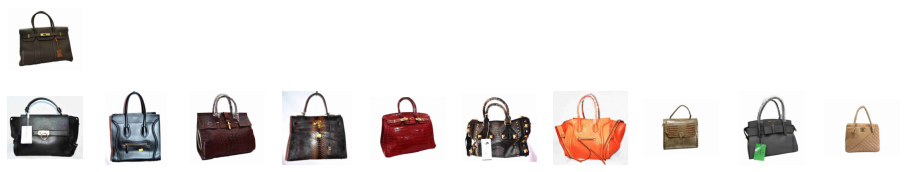

In [27]:
recommend_items(items[429])

We can now produce recommendations for all products of the database

## What you should remember

To build an Image-based recommender system, you need to
<ol>
    <li> Compute similarities between images of your products. 
        <ul>
            <li>By Transfer Learning, use a pretrained convolutional neural network (<a href="https://arxiv.org/pdf/1409.1556">VGG</a>, <a href="https://research.google.com/pubs/archive/43022.pdf">Inception (GoogLeNet)</a>, <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf">ResNet</a>) to extract embeddings (image features) of your images. You can also train your CNN if you have enough images, but transfer learning generally works well.</li>
            <li>Compute similarities between image's features to know the top-$k$ similar images for a given product. $k$-NN libraries may be useful : <a href="https://github.com/nmslib/nmslib">nmslib</a> (Non-Metric Space Library), <a href="https://pypi.org/project/annoy/">annoy</a> (Approximate Nearest Neighbors Oh Yeah), <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html">Scikit-Learn</a>, etc.</li>
        </ul>
    </li>
    <li>Save similar items for each products in your database to avoid huge online computations.</li>
    <li>To recommend products with similar images, just read the saved similar products and display them to the user.</li>
</ol>

This recommendation process actually work on <a href="https://shoppinglist.cm/fr/">ShoppingList</a> (an e-commerce plateform in Cameroon) for fashion products.

You too can implement it on your platform and adapt it according to your needs.

## References

<i>Christian Szegedy et al. (2015)</i>. <a href="https://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/43022.pdf">Going Deeper with Convolutions</a>

## Author

<b><i>Carmel WENGA</i></b>, Applied Machine Learning Research Engineer | <a href="https://shoppinglist.cm/fr/">ShoppingList</a>, Nzhinusoft